#Simple Restaurant Chatbot

<font color='seagreen'> **Highly recommended to run entire notebook using a CUDA GPU. Because a distilBERT transformer training model is used.**
**Using Google Colab's CPU results in training time that takes around 8 minutes.** </font?

<font color='palevioletred'>GO TO "3. Import Domain Specific Dataset" in Table of contents to change the google drive path if you want to import the JSON dataset </font>

I was able to connect to my local runtime and used a CUDA configured GPU and CUDA configured PyTorch that resulted in about 30 seconds of training time.

# 1.&nbsp;Preliminary Imports

## Mount Google Drive Directory (Comment/Uncomment to Skip/Run):

In [ ]:
'''
from google.colab import drive
drive.mount('/content/gdrive')
'''

"\nfrom google.colab import drive\ndrive.mount('/content/gdrive')\n"

## Upload to Cloud (Comment/Uncomment to Skip/Run)

In [ ]:
'''
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
'''

'\nfrom google.colab import files\n\nuploaded = files.upload()\n\nfor fn in uploaded.keys():\n  print(\'User uploaded file "{name}" with length {length} bytes\'.format(\n      name=fn, length=len(uploaded[fn])))\n'

## spaCy and Pretrained Model Import

https://spacy.io/models/en

In [ ]:
import spacy
from spacy import displacy
model = "en_core_web_sm" # 12 MB english model if need to download
nlp = spacy.load(model)

#!python -m spacy download en_core_web_md # 40 MB English model if need to download
#!python -m spacy download en_core_web_lg # 560 MB English model if need to download

# 2.&nbsp;spaCy User Input Analysis


## Entity (NER)

### NER Labels in Pre-Trained spaCy Model

In [ ]:
ner_labels = nlp.get_pipe("ner").labels

for index, label in enumerate(ner_labels, start=1):
    print(f"{index}. {label}")

1. CARDINAL
2. DATE
3. EVENT
4. FAC
5. GPE
6. LANGUAGE
7. LAW
8. LOC
9. MONEY
10. NORP
11. ORDINAL
12. ORG
13. PERCENT
14. PERSON
15. PRODUCT
16. QUANTITY
17. TIME
18. WORK_OF_ART


spaCy NER categories arranged in alphabetical order along with their descriptions:

1. CARDINAL - Numerals that do not fall under another type.
2. DATE - Absolute or relative dates or periods.
3. EVENT - Named hurricanes, battles, wars, sports events, etc.
4. FAC - Buildings, airports, highways, bridges, etc.
5. GPE - Countries, cities, states.
6. LANGUAGE - Any named language.
7. LAW - Named documents made into laws.
8. LOC - Non-GPE locations, mountain ranges, bodies of water.
9. MONEY - Monetary values, including unit.
10. NORP - Nationalities or religious or political groups.
11. ORDINAL - "first", "second", etc.
12. ORG - Companies, agencies, institutions, etc.
13. PERCENT - Percentage, including "%".
14. PERSON - People, including fictional.
15. PRODUCT - Objects, vehicles, foods, etc. (Not services.)
16. QUANTITY - Measurements, as of weight or distance.
17. TIME - Times smaller than a day.
18. WORK_OF_ART - Titles of books, songs, etc.

https://www.kaggle.com/code/ritesh2000/spacy-guide-all-in-one#Table-of-Contents

### Entity (NER) Function

In [ ]:
entity_descriptions = {
    "CARDINAL": "Numerals that do not fall under another type.",
    "DATE": "Absolute or relative dates or periods.",
    "EVENT": "Named hurricanes, battles, wars, sports events, etc.",
    "FAC": "Buildings, airports, highways, bridges, etc.",
    "GPE": "Countries, cities, states.",
    "LANGUAGE": "Any named language.",
    "LAW": "Named documents made into laws.",
    "LOC": "Non-GPE locations, mountain ranges, bodies of water.",
    "MONEY": "Monetary values, including unit.",
    "NORP": "Nationalities or religious or political groups.",
    "ORDINAL": "first, second, etc.",
    "ORG": "Companies, agencies, institutions, etc.",
    "PERCENT": "Percentage, including %.",
    "PERSON": "People, including fictional.",
    "PRODUCT": "Objects, vehicles, foods, etc. (Not services.)",
    "QUANTITY": "Measurements, as of weight or distance.",
    "TIME": "Times smaller than a day.",
    "WORK_OF_ART": "Titles of books, songs, etc."
}

#Formatting for easy to read terminal output
def Entity_Extractor(user_input, entity_descriptions):
    unique_entity = set([ent.label_ for ent in doc.ents])

    total_entities = len(doc.ents)
    total_unique_entity = len(unique_entity)

    print(f"Total NER entities: {total_entities}")
    print(f"Total unique NER entities: {total_unique_entity}")
    print()

    if not doc.ents:
        print("There are no spaCy NER entities in your input.")
        return

    max_entity_length = max(len(ent.text) for ent in doc.ents) if doc.ents else 0
    max_label_length = max(len(ent.label_) for ent in doc.ents) if doc.ents else 0
    max_explain_length = max(len(description) for description in entity_descriptions.values()) if entity_descriptions else 0

    column_widths = [max_entity_length + 2, max_label_length + 4, max_explain_length + 4]

    max_index_digits = len(str(total_entities))

    # Header (Adjust the spacing)
    header_line = [
        f"{' ' * max_index_digits}{' ' * 2}Entity{' ' * (column_widths[0] - max_index_digits - len('Entity') - 2)}", # Adjustment
        f"{' ' * 4}Label{' ' * (column_widths[1] - len('Label') - 4)}",
        f"{' ' * 4}Description{' ' * (column_widths[2] - len('Description') - 4)}"
    ]
    print(" ".join(header_line))
    print("-"*169)

    # Entity Output
    entity_index = 1  # Start the index at 1
    for ent in doc.ents:
        description = entity_descriptions.get(ent.label_)

        # Calculate spacing for index
        max_index_digits = len(str(total_entities))
        index_spacing = ' ' * (max_index_digits - len(str(entity_index)))

        # Create the formatted line with an index
        line = [
            f"{index_spacing}{entity_index}) {ent.text:{column_widths[0]}}",
            f"{ent.label_:{column_widths[1]}}",
            f"{description:{column_widths[2]}}"
        ]
        print(" ".join(line))

        entity_index += 1  # Increment the index for the next entity

    if doc.ents:
         print()
         displacy.render(doc, style="ent")
    print("*"*169)
    print()

## Tokenization, POS & Lemmatization Function


In [ ]:
# Display tokens, POS tagging and lemmas
# Formatting for easy to read terminal ouput
def Tagger(user_input):

    # Total token count calculation
    total_tokens = len(doc)

    # Print the total token count
    print(f"Total tokens: {total_tokens}")
    print()

    max_index_digits = len(str(len(doc)))

    token_lengths = []
    pos_lengths = []
    explanation_lengths = []
    lemma_lengths = []

    # Populate the lists with lengths of each attribute
    for token in doc:
        token_lengths.append(len(token.text))
        pos_lengths.append(len(token.pos_))
        explanation_lengths.append(len(spacy.explain(token.tag_)))
        lemma_lengths.append(len(token.lemma_))

    # Calculate maximum lengths
    max_token_length = max(token_lengths) if token_lengths else 0
    max_pos_length = max(pos_lengths) if pos_lengths else 0
    max_explanation_length = max(explanation_lengths) if explanation_lengths else 0
    max_lemma_length = max(lemma_lengths) if lemma_lengths else 0

    # Adjust column widths based on the maximum lengths
    column_widths = [
        max_token_length + 2,  # Adding some padding
        max_pos_length + 2,
        max_explanation_length + 2,
        max_lemma_length + 2
    ]

    # Adjust the first column width to account for the index length
    column_widths[0] += max_index_digits + 2  # Adding space for index and parenthesis

    # Header
    header_line = [
        f"{' ' * max_index_digits}{' ' * 2}Token{' ' * (column_widths[0] - max_index_digits - len('Token') - 2)}",  # Adjustment
        f"POS{' ' * (column_widths[1] - len('POS'))}",
        f"POS Explanation{' ' * (column_widths[2] - len('POS Explanation'))}",
        f"Lemma{' ' * (column_widths[3] - len('Lemma'))}",
    ]
    print(" ".join(header_line))

    print("-"*169)

    token_index = 1
    for token in doc:
        # Format the index with dynamic spacing based on its length
        index_spacing = ' ' * (max_index_digits - len(str(token_index)))

        # Adjust the formatting string to align the output
        line = [
            f"{index_spacing}{token_index}) {token.text:<{column_widths[0] - (max_index_digits + 2)}}",
            f"{token.pos_:<{column_widths[1]}}",
            f"{spacy.explain(token.tag_):<{column_widths[2]}}",
            f"{token.lemma_:<{column_widths[3]}}"
        ]
        print(" ".join(line))
        token_index += 1

    print("*"*169)
    print()
    print()

## Paragraph Example

The following carefully written paragraph in <font color='seagreen'> green </font> contains all 18 spaCy NERs in pretrained model (en_core_web_sm).

This model is not very intelligent or has a higher knowledge base and hence you have to carefully write a paragraph that makes sense, flows and can produce all the correct NERs within the model.

The pretrained model cannot recognize a lot of elements within a specific NER category (e.g. WORKS_OF_ART, PRODUCT).

<font color='seagreen'> **In 2069 at 4.20 p.m., people in the USA remembered Joe Biden died long ago and the Holocaust. About 420 meters near the Golden Gate Bridge, which is near the Pacific Ocean, the Constitution was read out loud in English and 69,420 Americans first heard it. A guy was playing The Legend of Zelda on his phone. Food vendors there sold hot dogs for $4.20, hoping to make a 69% profit margin. Security was also nearby and making sure that Apple sellers were not selling more vintage iPods to the crowd.** </font>







## spaCy Paragraph Example Analysis

In [ ]:
print()
print("Analyze generic paragraph example with all 18 NERs using spaCy's pretrained model", "'" + model + "'")
print()

generic_example = """In 2069 at 4.20 p.m., people in the USA remembered Joe Biden died long ago and the Holocaust. About 420 meters near the Golden Gate Bridge, which is near the Pacific Ocean, the Constitution was read out loud in English and 69,420 Americans first heard it. A guy was playing The Legend of Zelda on his phone. Food vendors there sold hot dogs for $4.20, hoping to make a 69% profit margin. Security was also nearby and making sure that Apple sellers were not selling more vintage iPods to the crowd."""

doc = nlp(generic_example)

print("*"*169)
Entity_Extractor(generic_example, entity_descriptions)
Tagger(generic_example)
print()
print("SCROLL UP THIS CODE CELL OUTPUT TO SEE ALL THE CONTENT!")


Analyze generic paragraph example with all 18 NERs using spaCy's pretrained model 'en_core_web_sm'

*************************************************************************************************************************************************************************
Total NER entities: 18
Total unique NER entities: 18

    Entity                   Label           Description                                         
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 1) 2069                     DATE            Absolute or relative dates or periods.                  
 2) 4.20 p.m.                TIME            Times smaller than a day.                               
 3) USA                      GPE             Countries, cities, states.                              
 4) Joe Biden                PERSON          People, including fictional.                            

*************************************************************************************************************************************************************************

Total tokens: 102

     Token          POS     POS Explanation                                      Lemma         
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
  1) In             ADP     conjunction, subordinating or preposition            in            
  2) 2069           NUM     cardinal number                                      2069          
  3) at             ADP     conjunction, subordinating or preposition            at            
  4) 4.20           NUM     cardinal number                                      4.20          
  5) p.m.           NOUN    noun, singular or mass                               p.m.          
  6) ,              PUNCT   punctuation mark, comma             

#` spaCy Analysis Function (Terminal I/O) [Comment/Uncomment to Skip/Run]`

Uncomment the entire code cell below to analyze your own user input to see NER, tokens, POS & Lemmas after running all the code cells above

In [ ]:
'''

user_input_counter = 1
while True:

    print("Analyze your input using spaCy's pretrained model 'en_core_web_sm'.")
    print("***Enter 'exit' or 'quit' to terminate this spaCy input analyzer***")
    print()
    user_input = input(f"You (User Input {user_input_counter}): ")
    doc = nlp(user_input)
    if user_input.lower() == "exit" or user_input.lower() == "quit":
        print("***Sucessfully quit program***")
        break
    print("-"*169)
    Entity_Extractor(user_input, entity_descriptions)
    Tagger(user_input)

    user_input_counter += 1

'''

'\n\nuser_input_counter = 1\nwhile True:\n\n    print("Analyze your input using spaCy\'s pretrained model \'en_core_web_sm\'.")\n    print("***Enter \'exit\' or \'quit\' to terminate this spaCy input analyzer***")\n    print()\n    user_input = input(f"You (User Input {user_input_counter}): ")\n    doc = nlp(user_input)\n    if user_input.lower() == "exit" or user_input.lower() == "quit":\n        print("***Sucessfully quit program***")\n        break\n    print("-"*169)\n    Entity_Extractor(user_input, entity_descriptions)\n    Tagger(user_input)\n\n    user_input_counter += 1\n\n'

# 3.&nbsp;Import Domain Specific Dataset

I prefer a JSON dataset file format because of its versatility, hierarchical nature and ease of editing on VS Code.

In [ ]:
# edit the gdrive_path accordingly on your own Google Drive account
gdrive_path = '/content/gdrive/MyDrive/Colab Notebooks/MA4891 AL ML/CA1 Text Chatbot Project/Datasets/CA1_Dataset_Max_Shi_Ziyi.json'
local_path = 'C:/Users/maxzi/Downloads/CA1_Dataset_Max_Shi_Ziyi.json'
gcloud_path = 'CA1_Dataset_Max_Shi_Ziyi.json'

import json
# Load the JSON file
with open(local_path) as f:
    data = json.load(f)

#JSON data format looks like: {'topics': [{'intent': ..., 'text': [...], 'response': [...]}, ...]}

# Initialize a list to hold all text elements
texts = []

# Iterate over each item in 'data' and extend the texts list with each 'text' from every 'intent'
for item in data['topics']:
    texts.extend(item['text'])

# Initialize a list to hold all 'intent' indices for each 'text' belonging in the same 'intent'
intent_indices = []
# Create a mapping from 'intent' to numerical indices
unique_intents = {item['intent']: idx for idx, item in enumerate(data['topics'])}

# Iterate over each item in 'intent' to process the 'text' list
for item in data['topics']:
    intent_index = unique_intents[item['intent']]
    # Append the intent index for each 'text' in the current item's 'text' list
    for _ in item['text']:
        intent_indices.append(intent_index)

labels = intent_indices

print ("Text:", texts)
print("-"*69420)
print ("Intent Indices (Labels for Text):", labels)

Text: ['I have problems with canceling an order', 'how can I find information about canceling orders?', 'I need help with canceling the last order', 'could you help me cancelling the last order I made?', 'problem with cancelling an order I made', 'can you help me canceling my last order?', 'I do not know how to cancel the last order I have made', 'problems with canceling my orders', 'I have problems with cancelling the last order I have made', 'could you give me information about order cancellations?', 'I need help canceling the last order I have made', 'I need help with cancelling the order I made', 'I do not want the order', 'how could I find information about cancelling an order?', 'would you give me information about order cancellations?', 'I have problems with cancelling my order', 'how to cancel an order?', 'I have problems with cancelling an order I have made', 'assistance with cancelling the order I made', 'can you give me information about canceling an order?', 'problems with 

## Visualize Dataset Distribution

Intent: Cancel Order, Text Count: 305
Intent: Feedback Submission Query, Text Count: 315
Intent: Change Order [Add/Remove], Text Count: 304
Intent: Refund, Text Count: 294
Intent: Buy Menu Item, Text Count: 306
Intent: Payment Issue, Text Count: 323
Total number of 'text': 1847



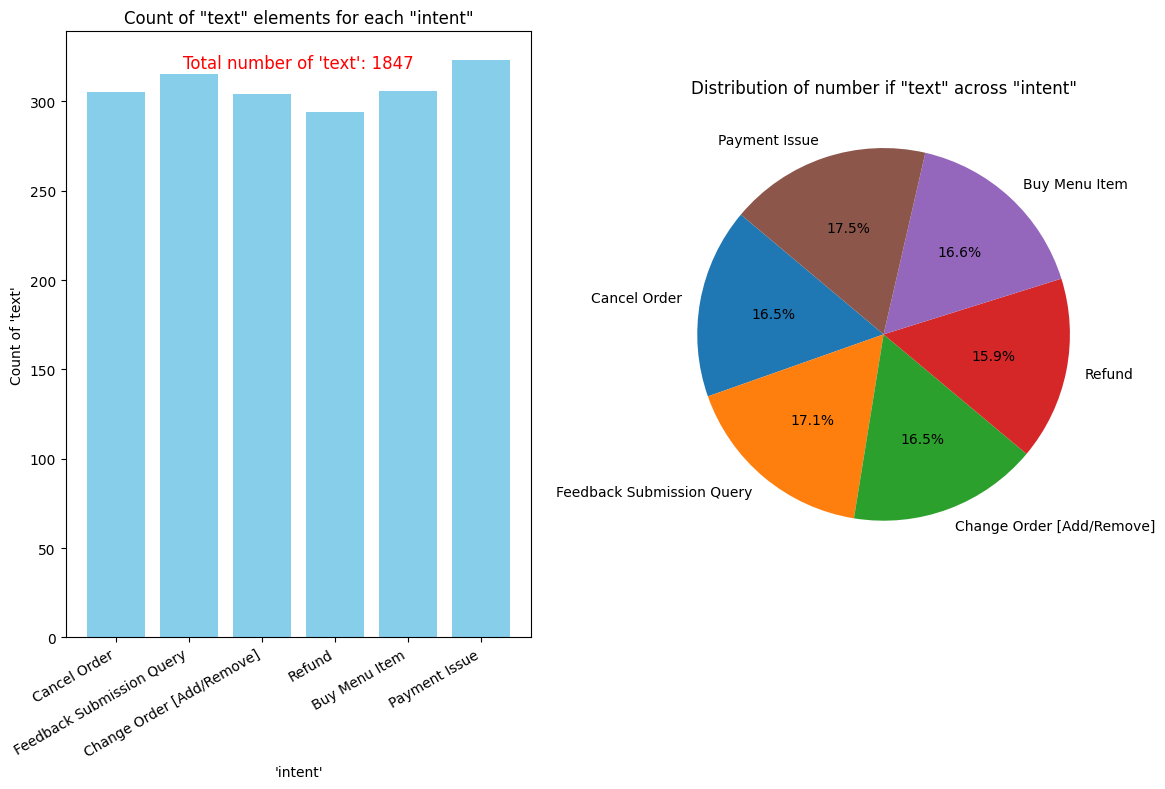

In [ ]:
import matplotlib.pyplot as plt

intent_text_count = {}
total_texts = 0
for topic in data['topics']:
    intent = topic['intent']
    text_count = len(topic['text'])
    total_texts += text_count
    intent_text_count[intent] = text_count
    print(f"Intent: {intent}, Text Count: {text_count}")

print(f"Total number of 'text': {total_texts}")
print()

# Data for plotting
intents = list(intent_text_count.keys())
counts = list(intent_text_count.values())

# Creating the bar plot
plt.figure(figsize=(12, 8))

plt.subplot(1, 2, 1)
plt.bar(intents, counts, color='skyblue')
plt.xlabel("'intent'")
plt.ylabel("Count of 'text'")
plt.title('Count of "text" elements for each "intent"')
plt.xticks(rotation=90)

# Add custom text for the total number of 'text'
total_texts_message = f"Total number of 'text': {total_texts}"
plt.text(0.5, 0.94, total_texts_message, transform=plt.subplot(1, 2, 1).transAxes, ha='center', fontsize=12, color='red')

# Automatically adjust the x-axis labels to fit better
plt.gcf().autofmt_xdate()

# Creating the pie chart
plt.subplot(1, 2, 2)
plt.pie(counts, labels=intents, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of number if "text" across "intent"')

plt.tight_layout()
plt.show()

## spaCy Preprocessing

spaCy preprocessing using the 'en_core_web_sm' model for lemmatization & removal of stop words



In [ ]:
def preprocess_sentences(sentences):
    preprocessed_sentences = []

    for sentence in sentences:
        # Process the sentence using the spaCy model
        doc = nlp(sentence)

        # Generate a list of lemmatized tokens that are not stop words
        lemmatized_tokens = [token.lemma_ for token in doc if not token.is_stop]

        # Reconstruct the sentence from the lemmatized tokens
        preprocessed_sentence = " ".join(lemmatized_tokens)

        preprocessed_sentences.append(preprocessed_sentence)

    return preprocessed_sentences

spaCy_texts = preprocess_sentences(texts)

print(spaCy_texts)

['problem cancel order', 'find information cancel order ?', 'need help cancel order', 'help cancel order ?', 'problem cancel order', 'help cancel order ?', 'know cancel order', 'problem cancel order', 'problem cancel order', 'information order cancellation ?', 'need help cancel order', 'need help cancel order', 'want order', 'find information cancel order ?', 'information order cancellation ?', 'problem cancel order', 'cancel order ?', 'problem cancel order', 'assistance cancel order', 'information cancel order ?', 'problem cancel order', 'know cancel order', 'like cancel order', 'need help cancel order', 'information cancel order ?', 'need help cancel order', 'problem cancel order', 'question cancel order', 'problem cancel order', 'problem cancel order', 'cancel order ?', 'information order cancellation ?', 'pay order', 'need assistance cancel order', 'try find information order cancelation', 'want help cancel order', 'need help cancel order', 'cancel order ?', 'possible cancel order 

Note: This may not be necessary since the preprocessed 'texts' list will be fed into a distilBERT transformer model later which is powerful by itself. It may even be more detrimental because context will be lost. However, from empirical observation, training speed using PyTorch marginally improved...

# 4.&nbsp;Prepare For Training

In [ ]:
# !pip install accelerate -U #from !pip install transformers[torch] Necessary for Google Colab Environment

In [ ]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments, TrainerCallback, EarlyStoppingCallback
from sklearn.model_selection import train_test_split
import pandas as pd
from torch.utils.data import Dataset, DataLoader

In [ ]:
train_texts, val_texts, train_labels, val_labels = train_test_split(spaCy_texts, labels, test_size=0.2)
# test in the function refers to validation data

In [ ]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

In [ ]:
class IntentDataset(Dataset):
    def __init__(self, spaCy_texts, labels):
        self.encodings = tokenizer(spaCy_texts, truncation=True, padding=True, max_length=128)
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [ ]:
# Prepare datasets
train_dataset = IntentDataset(train_texts, train_labels)
val_dataset = IntentDataset(val_texts, val_labels)

In [ ]:
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=len(set(labels))) #268 MB

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Terminal code output above essentially means distilBERT model's last classification layer is fine tuned for my domain specific dataset.

In [ ]:
# Return Validation Loss and Validation Accuracy
class CustomPrintCallback(TrainerCallback):
    def on_log(self, args, state, control, logs=None, **kwargs):
        # This method is called every time the `log` event is triggered
        # Check if logs contain evaluation metrics and print them
        if 'eval_loss' in logs:
            print(f"Step {state.global_step}: Validation Loss = {logs['eval_loss']}")
        if 'eval_accuracy' in logs:
            print(f"Step {state.global_step}: Validation Accuracy = {logs['eval_accuracy']}")


In [ ]:
import numpy as np

from sklearn.metrics import accuracy_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {"accuracy": accuracy_score(labels, predictions)}

In [ ]:
# Global lists to store metrics
global_metrics = {
    'training_loss': [],
    'validation_loss': [],
    'validation_accuracy': []
}

class CustomMetricsLogger(TrainerCallback):
    def on_log(self, args, state, control, logs=None, **kwargs):
        # This method is triggered at logging steps
        if 'loss' in logs:  # Training loss is logged by Trainer
            global_metrics['training_loss'].append((state.global_step, logs['loss']))
        if 'eval_loss' in logs:
            global_metrics['validation_loss'].append((state.global_step, logs['eval_loss']))
        if 'eval_accuracy' in logs:
            global_metrics['validation_accuracy'].append((state.global_step, logs['eval_accuracy']))

Good practice to always implement early stopping in supervised training in order to prevent overfitting.

In [ ]:
early_stopping_callback = EarlyStoppingCallback(early_stopping_patience=3)

## Begin Training (PyTorch)

<font color='seagreen'> **Highly recommended to run entire notebook using a CUDA GPU. Because a distilBERT transformer training model is used.**

**Using Google Colab's CPU results in training time that takes around 8 minutes.** </font>

I was able to connect to my local runtime and used a CUDA configured GPU and CUDA configured PyTorch that resulted in about 30 seconds of training time. Google Colab's free T4 GPU (not always connectable for free user) also resulted in training time of about 20 seconds.

In [ ]:
import torch
# Check if CUDA is available
if torch.cuda.is_available():
    # Get the current device
    device = torch.cuda.current_device()
    # Get the name of the current device
    device_name = torch.cuda.get_device_name(device)
    print(f"CUDA is available and the GPU is {device_name}")
    print()
    !nvidia-smi
else:
    print("CUDA is not available")

CUDA is available and the GPU is NVIDIA GeForce RTX 3070 Ti Laptop GPU

Mon Mar 11 01:55:54 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 551.61                 Driver Version: 551.61         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3070 ...  WDDM  |   00000000:01:00.0  On |                  N/A |
| N/A   55C    P8             14W /   80W |     237MiB /   8192MiB |      0%      Default |
|                                         |                        |

In [ ]:
# Hyperparameters of model
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=2,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=50,  # Log every 50 steps
    evaluation_strategy="steps",  # Evaluate every `eval_steps`
    eval_steps=50,  # Evaluate (and thus log eval metrics) every 50 steps
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
)

# Initialize Trainer (Prioritizes evaluation metrics)
# Abstracts away manual Optimizer and Loss Function implementation
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,  # Returns evaluation/validation accuracy, crucial in transformers
    callbacks=[CustomPrintCallback(), CustomMetricsLogger(), EarlyStoppingCallback(early_stopping_patience=3)]   # Returns validation loss and validation accuracy
)

# Train
trainer.train()

Step,Training Loss,Validation Loss,Accuracy
50,0.010100,0.007681,0.997297
100,0.008000,0.005081,0.997297
150,0.022200,0.004477,0.997297
200,0.017400,0.008814,0.994595
250,0.027400,0.010376,0.997297
300,0.014500,0.001033,1.000000
350,0.006500,0.015213,0.997297


Step 50: Validation Loss = 0.007680839393287897
Step 50: Validation Accuracy = 0.9972972972972973
Step 100: Validation Loss = 0.0050808582454919815
Step 100: Validation Accuracy = 0.9972972972972973
Step 150: Validation Loss = 0.004476602654904127
Step 150: Validation Accuracy = 0.9972972972972973
Step 200: Validation Loss = 0.008813953958451748
Step 200: Validation Accuracy = 0.9945945945945946
Step 250: Validation Loss = 0.010376247577369213
Step 250: Validation Accuracy = 0.9972972972972973
Step 300: Validation Loss = 0.0010334037942811847
Step 300: Validation Accuracy = 1.0
Step 350: Validation Loss = 0.015212837606668472
Step 350: Validation Accuracy = 0.9972972972972973


TrainOutput(global_step=370, training_loss=0.014349575157000406, metrics={'train_runtime': 21.7302, 'train_samples_per_second': 135.94, 'train_steps_per_second': 17.027, 'total_flos': 6878963836584.0, 'train_loss': 0.014349575157000406, 'epoch': 2.0})

## Training and Validation Visualizations (Graphs)

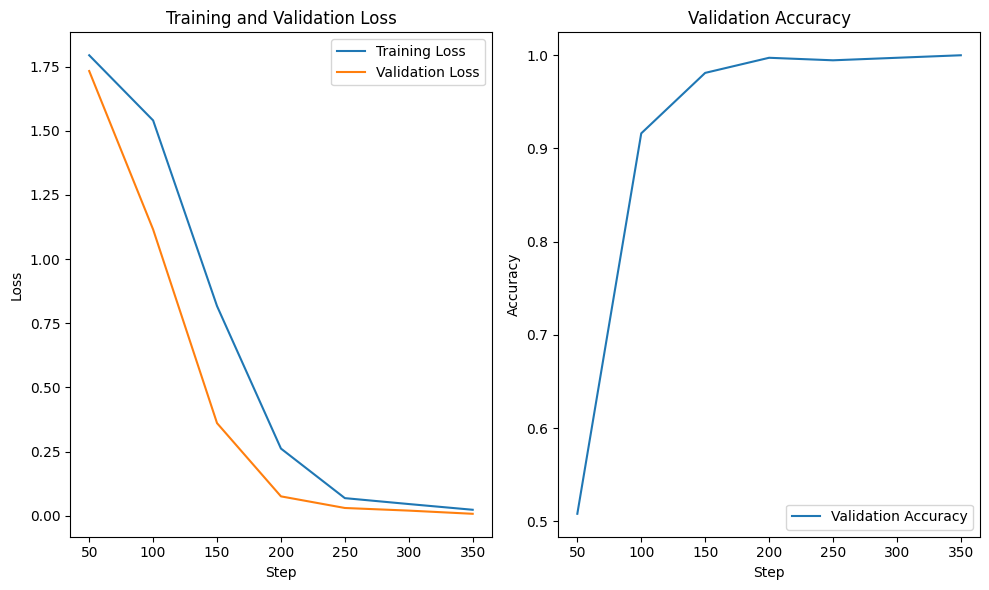

In [ ]:
import matplotlib.pyplot as plt

# Unpack the global metrics for plotting
steps, training_losses = zip(*global_metrics['training_loss'])
_, validation_losses = zip(*global_metrics['validation_loss'])
_, validation_accuracies = zip(*global_metrics['validation_accuracy'])

plt.figure(figsize=(10, 6))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(steps, training_losses, label='Training Loss')
plt.plot(steps, validation_losses, label='Validation Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot validation accuracy
plt.subplot(1, 2, 2)
plt.plot(steps, validation_accuracies, label='Validation Accuracy')
plt.xlabel('Step')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


Other metrics in Pytorch such as Precision, Recall and F1 Score do not seem too relevant and necessary as training results for my intent classification model.

It is also computationally intensive to retreieve training loss after a certain number of steps.

#<font color='seagreen'> ```Chatbot Terminal (I/O)``` </font>


In [ ]:
model.eval()  # May not be absolutely essential but always good to execute

print("I am a Simple Restaurant ChatBot. I can only understand and assist with 6 types of input.")
print("The menu items are: Donuts, Fried Rice, Hot Dogs, Pizza & Tea")
print("I can order items on the menu for you, change them (add/remove), cancel order(s), provide refunds, assist with payment issues and record your feedback. ")
print()
print("***Enter 'exit' or 'quit' to terminate this ChatBot***")
print()
print()

# Mapping from indices back to intent names
index_to_intent = {idx: intent for intent, idx in unique_intents.items()}
# Extract response from corresponding intent
intent_to_response = {item['intent']: item['responses'] for item in data['topics']}

user_input_counter = 1
confidence_threshold = 0.7  # Confidence threshold

# Manual testing with user input
while True:
    user_input = input(f"You (User Input {user_input_counter}): ")
    print("-"*169)
    if user_input.lower() == "exit" or user_input.lower() == "quit":
        print("*** Successfully Quit Terminal Chatbot ***")
        print("-"*169)
        break

    inputs = tokenizer(user_input, return_tensors="pt", truncation=True, padding=True, max_length=128)

    # Move inputs to the same device as the model
    inputs = {k: v.to(next(model.parameters()).device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)

        # Calculate softmax to obtain the probabilities
        probs = torch.nn.functional.softmax(outputs.logits, dim=-1)

        # Get the top prediction and its probability
        max_prob, predicted_class_id = torch.max(probs, dim=1)
        predicted_intent = index_to_intent[predicted_class_id.item()]

        # Check if the confidence is above the threshold
        if max_prob.item() < confidence_threshold:
            response = "I do not understand you, please rephrase."
        else:
            response = ' '.join(intent_to_response[predicted_intent])  # Assuming the response is a list of strings

        print(f"Response: {response} | Predicted intent: {predicted_intent} (Confidence: {max_prob.item():.2f})")
        print("-"*169)
        print("***Enter 'exit' or 'quit' to terminate this ChatBot***")

    print()
    print()
    user_input_counter += 1

I am a Simple Restaurant ChatBot. I can only understand and assist with 6 types of input.
The menu items are: Donuts, Fried Rice, Hot Dogs, Pizza & Tea
I can order items on the menu for you, change them (add/remove), cancel order(s), provide refunds, assist with payment issues and record your feedback. 

***Enter 'exit' or 'quit' to terminate this ChatBot***


You (User Input 1): quit
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
*** Successfully Quit Terminal Chatbot ***
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
